In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import datetime

device = torch.device("cuda:0")

path = "./车辆分类数据集/bus/bus001.jpg"
train_features = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
test_features = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)

# 处理客车数据，总共218张，前153张为训练集，后65张为测试集
pic_num = 0
for filename in os.listdir("./车辆分类数据集/bus/"): 
    pic_num = pic_num + 1
    path = "./车辆分类数据集/bus/"+ filename
    img = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
    if pic_num <= 153:
        train_features = torch.cat((train_features,img), dim=0)
    else:
        test_features = torch.cat((test_features,img), dim=0)

# 处理汽车数据，总共779张，前545张为训练集，后234张为测试集
pic_num = 0
for filename in os.listdir("./车辆分类数据集/car/"): 
    pic_num = pic_num + 1
    path = "./车辆分类数据集/car/"+ filename
    img = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
    if pic_num <= 545:
        train_features = torch.cat((train_features,img), dim=0)
    else:
        test_features = torch.cat((test_features,img), dim=0)

# 处理货车数据，总共360张，前252张为训练集，后108张为测试集
pic_num = 0
for filename in os.listdir("./车辆分类数据集/truck/"): 
    pic_num = pic_num + 1
    path = "./车辆分类数据集/truck/"+ filename
    img = torch.Tensor(np.array(Image.open(path).resize((100,100),Image.ANTIALIAS))/255).view(1, 100, 100, 3)
    if pic_num <= 252:
        train_features = torch.cat((train_features,img), dim=0)
    else:
        test_features = torch.cat((test_features,img), dim=0)

train_features = train_features.permute(0,3,2,1)
test_features = test_features.permute(0,3,2,1)
print(train_features.shape)
print(test_features.shape)

# =================== 训练集标签 =================== #
train_labels = torch.zeros(154).long()
train_labels = torch.cat((train_labels,torch.ones(545).long()), dim=0)
train_labels = torch.cat((train_labels,torch.ones(252).long()+1), dim=0)
print(train_labels.shape)

# =================== 测试集标签 =================== #
test_labels = torch.zeros(66).long()
test_labels = torch.cat((test_labels,torch.ones(234).long()), dim=0)
test_labels = torch.cat((test_labels,torch.ones(108).long()+1), dim=0)
print(test_labels.shape)

torch.Size([951, 3, 100, 100])
torch.Size([408, 3, 100, 100])
torch.Size([951])
torch.Size([408])


In [9]:
# ========================= 定义模型 ========================= #
 
class ResNet(torch.nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
#第0层 in_channel=3 out_channel=64
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
#第1层 in_channel=64 out_channel=64
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False, dilation=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
#第2层 in_channel=64 out_channel=64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=2, bias=False, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
#第3层 in_channel=64 out_channel=64
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=3, bias=False, dilation=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer3_shortcout = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(64)
        ) 
        self.layer3_relu = nn.ReLU(inplace=True)

#第4层 in_channel=64 out_channel=128
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )        
#第5层 in_channel=64 out_channel=128
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=2, bias=False, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
#第6层 in_channel=128 out_channel=128
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=3, bias=False,dilation=3),
            nn.BatchNorm2d(128)
        )        
        self.layer6_shortcout = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(128)
        ) 
        self.layer6_relu = nn.ReLU(inplace=True)
       
        self.fc = nn.Linear(128, num_class)
        
    def forward(self, x):
        out0 = self.layer0(x)
        
        out1 = self.layer1(out0)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out3 = out3 + self.layer3_shortcout(out0)
        out3 = self.layer3_relu(out3)
        
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        out6 = out6 + self.layer6_shortcout(out3)
        out6 = self.layer6_relu(out6)
        
        #print(out8.shape) #torch.Size([128, 128, 50, 50])
        out = nn.functional.avg_pool2d(out6, 50)
        #print(out.shape) #torch.Size([128, 128, 1, 1])
        out = out.squeeze()
        #print(out.shape) #torch.Size([128, 128])
        out = self.fc(out)
        return out

In [11]:
#训练函数
def train_epoch(net, data_loader, device):
    
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

#测试函数
def test_epoch(net, data_loader, device):
    
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

num_class = 3
num_epoch = 50
lr = 0.001
batch_size = 128

#划分数据集
train_dataset = torch.utils.data.TensorDataset(train_features,train_labels)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
test_dataset = torch.utils.data.TensorDataset(test_features,test_labels)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=0)

In [13]:
# ==================== 残差网络 ==================== #

net = ResNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_loss_num = []
train_acc_num = []
test_loss_num = []
test_acc_num = []

start = datetime.datetime.now()
for epoch in range(num_epoch):
    
    train_loss, train_acc = train_epoch(net, train_iter, device)
    test_loss, test_acc = test_epoch(net, test_iter, device)
    
    train_loss_num.append(train_loss)
    train_acc_num.append(train_acc)
    test_loss_num.append(test_loss)
    test_acc_num.append(test_acc)
    
    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f' % 
          (epoch+1, train_loss, test_loss, train_acc, test_acc))
end = datetime.datetime.now()
print("残差网络与空洞卷积结合执行时间：",end - start)

epoch 1, train_loss 0.608154, test_loss 1.357467, train_acc 0.744479, test_acc 0.291667
epoch 2, train_loss 0.441460, test_loss 2.366440, train_acc 0.841220, test_acc 0.352941
epoch 3, train_loss 0.352389, test_loss 1.053979, train_acc 0.861199, test_acc 0.642157
epoch 4, train_loss 0.350414, test_loss 1.878252, train_acc 0.883281, test_acc 0.397059
epoch 5, train_loss 0.316657, test_loss 0.678718, train_acc 0.891693, test_acc 0.776961
epoch 6, train_loss 0.269010, test_loss 0.574358, train_acc 0.901157, test_acc 0.786765
epoch 7, train_loss 0.258186, test_loss 0.287085, train_acc 0.916930, test_acc 0.867647
epoch 8, train_loss 0.257497, test_loss 0.319976, train_acc 0.911672, test_acc 0.872549
epoch 9, train_loss 0.212498, test_loss 0.377210, train_acc 0.927445, test_acc 0.884804
epoch 10, train_loss 0.196912, test_loss 0.371100, train_acc 0.932702, test_acc 0.843137
epoch 11, train_loss 0.210880, test_loss 0.365109, train_acc 0.931651, test_acc 0.897059
epoch 12, train_loss 0.199710,

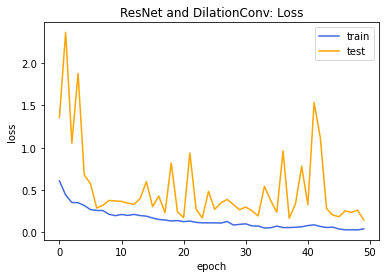

In [16]:
plt.plot(train_loss_num ,label='train',color='royalblue')
plt.plot(test_loss_num ,label='test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("ResNet and DilationConv: Loss")
plt.legend()
plt.show()

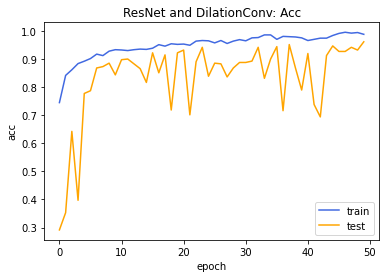

In [17]:
plt.plot(train_acc_num ,label='train',color='royalblue')
plt.plot(test_acc_num ,label='test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("ResNet and DilationConv: Acc")
plt.legend()
plt.show()